# AxCaliber

To estimate the axon diameter distribution itself, *(Assaf et al. 2008)* proposed a method called AxCaliber.
In AxCaliber, a distribution of cylinders with different diameters are fitted to the diffusion signal. In particular, a Gamma distribution is used. A requirement of this technique is that the signal is measured perpendicular to the axon bundle direction for different gradient strengths and diffusion times.
The signal representation in AxCaliber is given as

\begin{equation}
E_{\textrm{MMWMD}}=\underbrace{f_{\textrm{CSF}}\overbrace{E_{\textrm{iso}}(\cdot|D_{\textrm{iso}})}^{\textrm{Ball}}}_{\textrm{CSF}}+
\underbrace{f_{\textrm{trap}}\times\overbrace{1}^{\textrm{Dot}}}_{\textrm{Trapped Water}}+
\underbrace{f_h\overbrace{E_h(\boldsymbol{\mu}|\lambda_\parallel,\lambda_\perp^{\textrm{tort}})}^{\textrm{Zeppelin}}}_{\textrm{Hindered Extra-Axonal}}+
\underbrace{f_r\overbrace{E_r(\boldsymbol{\mu}\langle D \rangle|\lambda_\parallel,\lambda_\perp)}^{\textrm{Cylinder}}}_{\textrm{Intra-Axonal}},
\end{equation}

where the cylinder was initially represented using the Callaghan model, but was later replaced with the more general Van Gelderen model *(Assaf et al. 2008, Huang et al. 2015, De Santis et al. 2016)*.

Advantages:
- Estimates the axon diameter distribution.

Limitations:
- Tissue orientation must be known for the signal to be measured perpendicular,
- Does not take axon dispersion into account,
- Does not include the effects of extra axonal restriction *(Burcaw et al. 2015)*.

## ActiveAx model with Gaussian Phase Approximation

The process of setting up the AxCaliber model with Gamma-distributed cylinder diameters is the same as setting up an axon dispersed model. We import the needed Ball and Cylinder models, and then distribute the cylinder using the DD1GammaDistributed function from distribute_models.

In [11]:
from dmipy.core import modeling_framework
from dmipy.distributions import distribute_models
from dmipy.signal_models import gaussian_models, cylinder_models, sphere_models

ball = gaussian_models.G1Ball()
cylinder = cylinder_models.C4CylinderGaussianPhaseApproximation()
dot = sphere_models.S1Dot()
zeppelin = gaussian_models.G2Zeppelin()
bundle = distribute_models.BundleModel([cylinder,zeppelin])
bundle.set_equal_parameter('C4CylinderGaussianPhaseApproximation_1_mu', 'G2Zeppelin_1_mu')
bundle.set_equal_parameter('C4CylinderGaussianPhaseApproximation_1_lambda_par', 'G2Zeppelin_1_lambda_par')
bundle.set_tortuous_parameter(
    'G2Zeppelin_1_lambda_perp', 'C4CylinderGaussianPhaseApproximation_1_lambda_par', 'partial_volume_0')
activax = modeling_framework.MultiCompartmentModel([ball, dot, bundle])

We highly recommend installing pathos to take advantage of multicore processing.


Then put the models together in a MultiCompartmentModel and display the parameters

In [12]:
activax.parameter_cardinality

OrderedDict([('BundleModel_1_partial_volume_0', 1),
             ('G1Ball_1_lambda_iso', 1),
             ('BundleModel_1_C4CylinderGaussianPhaseApproximation_1_mu', 2),
             ('BundleModel_1_C4CylinderGaussianPhaseApproximation_1_diameter',
              1),
             ('BundleModel_1_C4CylinderGaussianPhaseApproximation_1_lambda_par',
              1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1),
             ('partial_volume_2', 1)])

Visualize the model:

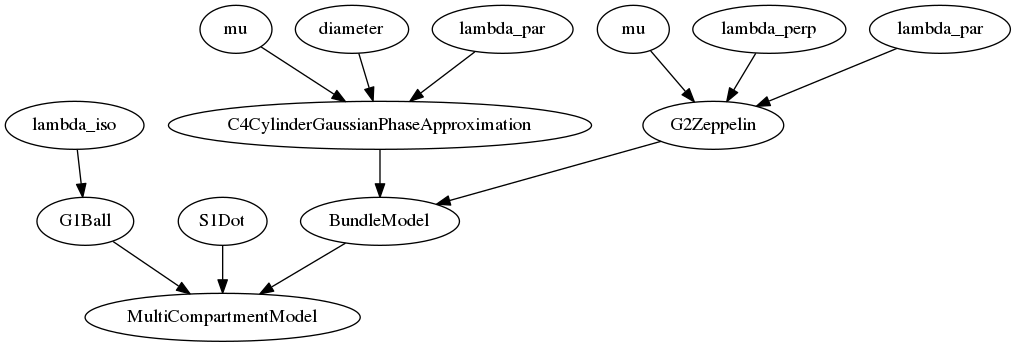

In [13]:
from IPython.display import Image
activax.visualize_model_setup(view=False, cleanup=False, with_parameters=True)
Image('Model Setup.png')

The data we will fit is measured only along 2 gradient orientations that are perpendicular to the axon axis (along x and y axis). This means there is no data that provides information to fit parallel diffusivity "lambda_par" or the axon orientation "mu". To not fit these superfluous parameters we fix mu along the z-axis and give lambda_par an arbitrary value (it will not affect the results).

## Load AxCaliber-compatible data

For the example data, we kindly make use of a cat spinal cord dataset hosted at the White Matter Microscopy Database (https://osf.io/yp4qg/). The data includes 2D Axcaliber data, 3D multi-shell data and the corresponding histology values for axon diameter, intra-axonal volume fraction (and others).

In [15]:
from dmipy.data import saved_data
scheme_spinal_cord, data_spinal_cord = saved_data.duval_cat_spinal_cord_3d()

This data was used by Duval et al. 'Validation of quantitative MRI metrics using full slice histology with automatic axon segmentation', ISMRM 2016. Reference at Cohen-Adad et al. White Matter Microscopy Database. http://doi.org/10.17605/OSF.IO/YP4QG


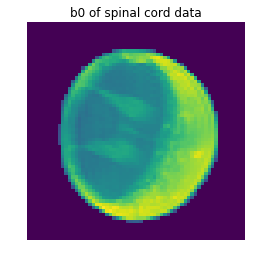

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(data_spinal_cord.signal[:,:,0,0])
plt.title('b0 of spinal cord data')
plt.axis('off');

Printing the acquisition scheme information we can see the Delta-shells of the acquisition.

In [17]:
scheme_spinal_cord.print_acquisition_info

Acquisition scheme summary

total number of measurements: 796
number of b0 measurements: 16
number of DWI shells: 4

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |16        |0               |0                        |3.0        |30.0      |47.2 
1           |195       |41              |47                       |3.0        |30.0      |47.2 
2           |195       |189             |100                      |3.0        |30.0      |47.2 
3           |195       |1681            |299                      |3.0        |30.0      |47.2 
4           |195       |6724            |599                      |3.0        |30.0      |47.2 


The 2D data only has data measured in the xy-plane, where we only use the [1, 0, 0] dummy direction for b0 measurements. We can see the unique gradient directions as follows:

## Fit AxCaliber to spinal cord data

It is known that a Gamma distribution is tricky to fit since there are several parameter combinations that produce similar distributions. We will use the stochastic MIX optimization *(Farooq et al. 2016)*, which is slow but is likely to robustly give the global minimum.

#### NOTE: Fitting AxCaliber to this dataset with MIX takes over 7 hours!

In [9]:
activeax_fit = activax.fit(
    scheme_spinal_cord, data_spinal_cord.signal,
    mask=data_spinal_cord.mask, solver='mix', maxiter=100)

Using parallel processing with 8 workers.
Setup MIX optimizer in 4.57763671875e-05 seconds
Fitting of 968 voxels complete in 30356.3031921 seconds.
Average of 31.3598173473 seconds per voxel.


## Visualize fitted parameter maps

We can visualize the fitted parameters as before:

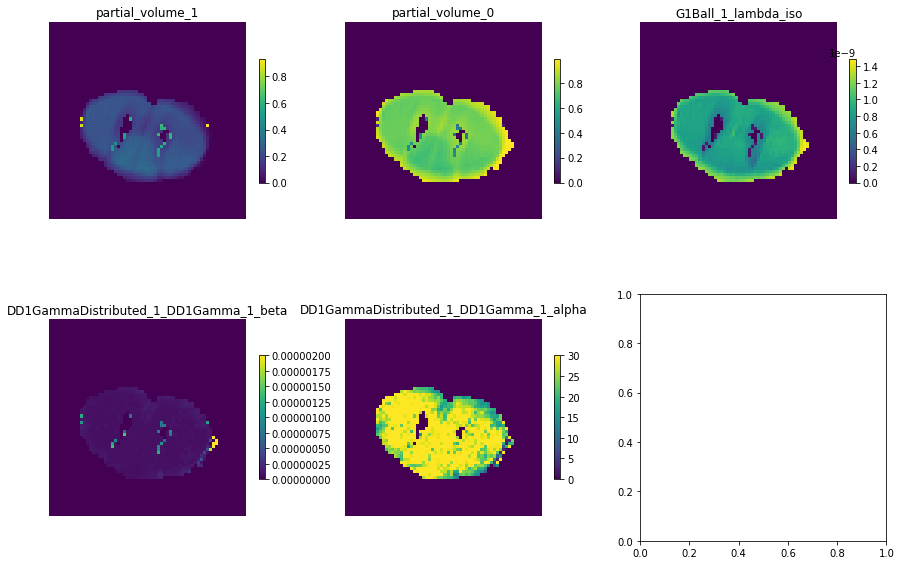

In [10]:
fitted_parameters = axcaliber_gamma_fit.fitted_parameters

fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    axs[counter].set_axis_off()
    fig.colorbar(cf, ax=axs[counter], shrink=0.5)
    counter += 1

We can see that the maps for alpha and beta are not super smooth. This could be because we're actually fitting two signals experiencing different restriction levels at the same time, but hard to say without fitting each signal separately. We can visualize the distributions themselves as follows:

## Comparison between estimated and histology axon diameter

The mean axon diameter can be estimated from the axon diameter distribution as diameter = 2$\alpha\beta$. We compare the histological axon diameter with the estimated ones:

In [16]:
mean_diameter = 2 * axcaliber_alpha * axcaliber_beta * 1e6  # in microns
mean_diameter_histology = data_spinal_cord.histology.h1_axonEquivDiameter  # was already in microns

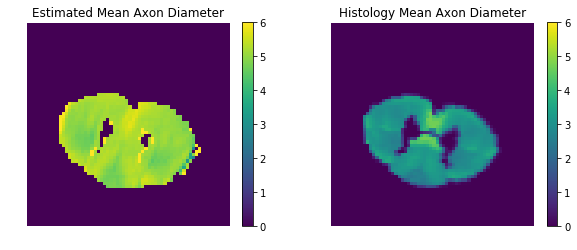

In [17]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[10, 5])

ax1plot = ax1.imshow(mean_diameter.squeeze().T,
           origin=True, vmax=6, interpolation='nearest')
ax1.set_title('Estimated Mean Axon Diameter')
ax1.set_axis_off()
plt.colorbar(ax1plot, ax=ax1, shrink=0.75)

ax2plot = ax2.imshow(mean_diameter_histology.T, 
           origin=True, vmax=6, interpolation='nearest')
ax2.set_title('Histology Mean Axon Diameter')
ax2.set_axis_off()
plt.colorbar(ax2plot, ax=ax2, shrink=0.75)

We can see that our estimated mean axon diameter map is completely smooth, aside from a few outliers in areas which actually lie outside of the white matter area (see right histology image). The estimated diameters are overestimated in general. We find between 4-6 $\mu$m, while the histological values are between 0-5 $\mu$m. 

Using the Seaborn package, we can nicely visualize the correlation between our estimated and the histology diameters. We separate visualize this correlation of axon diameters between 1-2$\mu$m, 2-3$\mu$m and 3+$\mu$m, and remove the exceptional outliers.

In [18]:
mean_diameter_mask12 = np.all([mean_diameter_histology > 1,
                               mean_diameter_histology < 2,
                               mean_diameter.squeeze() < 10], axis=0)
mean_diameter_mask23 = np.all([mean_diameter_histology > 2,
                               mean_diameter_histology < 3,
                               mean_diameter.squeeze() < 10], axis=0)
mean_diameter_mask3p = np.all([mean_diameter_histology > 3,
                               mean_diameter.squeeze() < 10], axis=0)

### Axon diameter correlation 1-2 $\mu$m - not significant

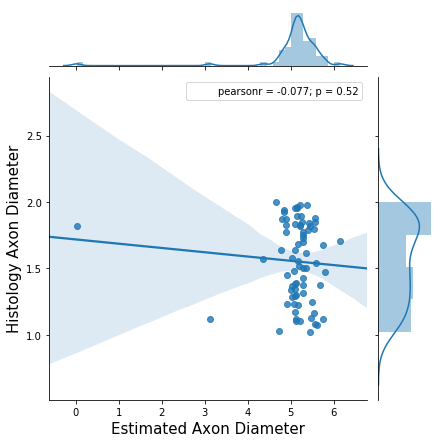

In [19]:
import seaborn as sns
mask = mean_diameter_mask12
im = sns.jointplot(mean_diameter[mask].squeeze(),
                   mean_diameter_histology[mask].squeeze(), kind="reg")
im.set_axis_labels("Estimated Axon Diameter", "Histology Axon Diameter", fontsize=15)

### Axon diameter correlation 2-3 $\mu$m - not significant

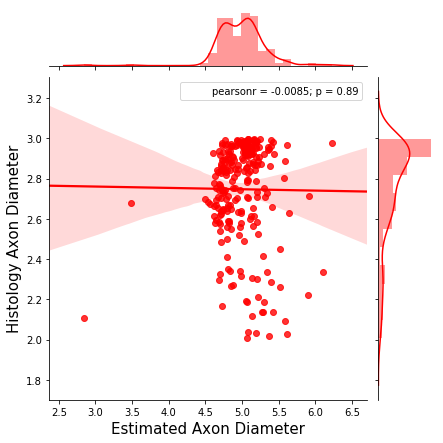

In [20]:
mask = mean_diameter_mask23
im = sns.jointplot(mean_diameter[mask].squeeze(),
                   mean_diameter_histology[mask].squeeze(), kind="reg", color='r')
im.set_axis_labels("Estimated Axon Diameter", "Histology Axon Diameter", fontsize=15)

### Axon diameter correlation 3+ $\mu$m - Significant

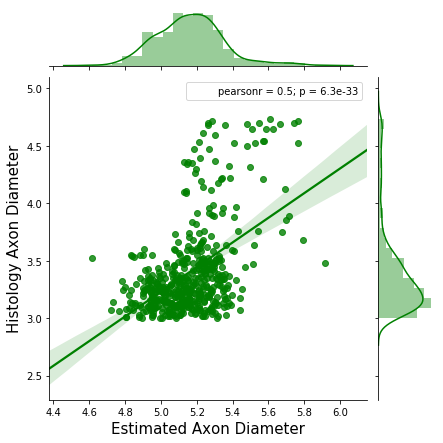

In [21]:
mask = mean_diameter_mask3p
im = sns.jointplot(mean_diameter[mask].squeeze(),
                   mean_diameter_histology[mask].squeeze(), kind="reg", color='g')
im.set_axis_labels("Estimated Axon Diameter", "Histology Axon Diameter", fontsize=15)

The results show that for our current approach to the data set we can only estimate axon diameters that correlate with the histology values for axon diameters of 3+$\mu$m.

## Comparison between estimated and histology volume fraction

Similarly, we can also visualize the estimated intra-axonal volume fraction between our model and the histology values.

In [22]:
axcaliber_fraction = axcaliber_gamma_fit.fitted_parameters['partial_volume_1'].squeeze()
histology_fraction = data_spinal_cord.histology.h4_fr

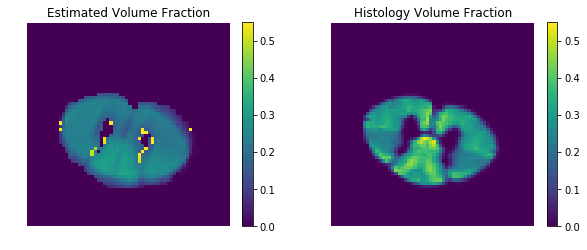

In [23]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[10, 5])

ax1plot = ax1.imshow(axcaliber_fraction.T,
           origin=True,interpolation='nearest', vmax=0.55)
ax1.set_title('Estimated Volume Fraction')
ax1.set_axis_off()
plt.colorbar(ax1plot, ax=ax1, shrink=0.75)

ax2plot = ax2.imshow(histology_fraction.T, 
           origin=True, interpolation='nearest', vmax=0.55)
ax2.set_title('Histology Volume Fraction')
ax2.set_axis_off()
plt.colorbar(ax2plot, ax=ax2, shrink=0.75)

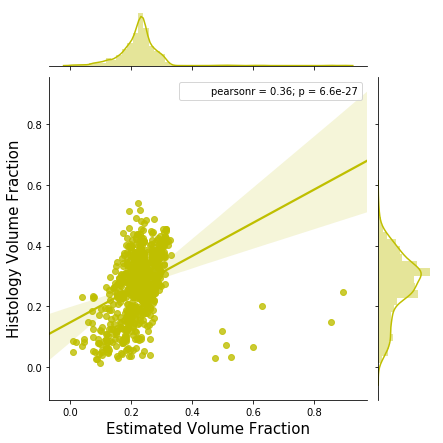

In [24]:
im = sns.jointplot(axcaliber_fraction[mean_diameter_histology > 1],
              histology_fraction[mean_diameter_histology > 1], kind="reg", color='y')
im.set_axis_labels("Estimated Volume Fraction", "Histology Volume Fraction", fontsize=15);

The results show that estimating intra-axonal volume fractions that correlate with histology is easier than doing the same for axon diameter. However, the model does systematically underestimate the value compared to histology.

## References
- Assaf, Yaniv, et al. "AxCaliber: a method for measuring axon diameter distribution from diffusion MRI." Magnetic resonance in medicine 59.6 (2008): 1347-1354.
- Burcaw, Lauren M., Els Fieremans, and Dmitry S. Novikov. "Mesoscopic structure of neuronal tracts from time-dependent diffusion." NeuroImage 114 (2015): 18-37.
- De Santis, Silvia, Derek K. Jones, and Alard Roebroeck. "Including diffusion time dependence in the extra-axonal space improves in vivo estimates of axonal diameter and density in human white matter." NeuroImage 130 (2016): 91-103.
- Farooq, Hamza, et al. "Microstructure imaging of crossing (MIX) white matter fibers from diffusion MRI." Scientific reports 6 (2016): 38927.
- Huang, Susie Y., et al. "The impact of gradient strength on in vivo diffusion MRI estimates of axon diameter." NeuroImage 106 (2015): 464-472.